# Nhận diện gương mặt với khẩu trang

# 1. Sơ lược dự án

Một trong những ứng dụng phổ biến của Máy học là **Nhận diện gương mặt**. Ứng dụng này có mặt hầu như ở mọi mặt trong đời sống xã hội cũng như khoa học công nghệ, chúng ta sử dụng nhận diện gương mặt để chấm công nhân viên, sử dụng nhận diện gương mặt cho mục đích an ninh, ... Ở dự án này, chúng ta cũng sẽ tiến hành tạo ra một mô hình nâng cao hơn. Vẫn là mô hình **nhận diện gương mặt**, nhưng lần này chúng ta sẽ tiến hành thêm một bước sau khi đã nhận diện được một gương mặt từ tấm ảnh hay video, đó là xem thử liệu một khuôn mặt **có đeo khẩu trang hay không**. Việc này có ứng dụng rất lớn trong bối cảnh dịch bệnh Covid hiện nay, tiến hành phát hiện sớm một người không đeo khẩu trang có thể giảm thiểu mức độ lây nhiễm xuống thấp, qua đó góp phần thúc đẩy việc đẩy lùi dịch bệnh một cách nhanh chóng và ít tốn kém hơn. Tức là mô hình của chúng ta sẽ hoạt động như sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trang hoặc không (3) --> Gán nhãn tương ứng (4)**

Chúng ta sẽ tạo ra mô hình ở **bước (3)** và sử dụng các mô hình nhận diện gương mặt có sẵn để tạo thành một pipeline hoàn chỉnh ở trên

Cụ thể, trong dự án này chúng ta sẽ thực hiện các bước sau:

1. Tạo ra một tập dữ liệu (bao gồm các gương mặt có và không có đeo khẩu trang) từ nhiều nguồn khác nhau.
2. Tiền xử lý dữ liệu
3. Chia tập dữ liệu dùng riêng cho mục đích huấn luyện và kiểm tra mô hình
4. Huấn luyện mô hình
5. Kiểm tra mô hình
6. Cải tiến

- Vẫn như các dự án máy học khác, điều đầu tiên chúng ta cần làm là import các thư viện cần thiết

In [1]:
import numpy as np
import sklearn
import cv2
import os
import random
import time
import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline


# 2. Khởi tạo tập dữ liệu

Lần này, dữ liệu sẽ không được cung cấp sẵn, bạn sẽ phải tự tạo ra một tập dữ liệu từ nhiều nguồn có sẵn và ghép chúng lại thành một tập dữ liệu duy nhất cho dự án này. 

1. Đầu tiên, bạn phải download các tập dữ liệu từ các nguồn sau đây

    - https://www.kaggle.com/andrewmvd/face-mask-detection
	- https://www.kaggle.com/omkargurav/face-mask-dataset
	- https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset
	- https://www.kaggle.com/vijaykumar1799/face-mask-detection
	- https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset
	- https://www.kaggle.com/spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask
	- https://www.kaggle.com/sumansid/facemask-dataset
	- https://drive.google.com/file/d/1m6Rd5nxol_cT2EKHSodli9HD1L6k0bKR/view
    
Bạn có thể thấy, các tập dữ liệu đã được chia nhỏ thành 2 thư mục riêng biệt, đó là **có đeo khẩu trang (with mask)** và **không đeo khẩu trang (without mask)**. Chúng có thể được chứa trong các thư mục lớn hơn nữa là train, validation và test; nhưng điều này không đáng kể, bạn chỉ cần lưu ý 2 thư mục đã nêu ở trên.

2. Bạn đem các ảnh tải được bỏ vào trong thư mục **dataset** theo cấu trúc sau:

```
dataset <- thư mục chứa ảnh dữ liệu cho dự án
└───with mask <- ảnh của các khuôn mặt có đeo khẩu trang được chứa trong thư mục này
│       1.jpg
│       ...
└───without mask <- ảnh của các khuôn mặt không có đeo khẩu trang được chứa trong thư mục này
│       2.jpg
│       ...         
```

**Lưu ý:** Có thể sẽ có một vài tấm ảnh bị trùng giữa các nguồn dữ liệu khác nhau, bạn chỉ cần bỏ qua quá trình sao chép các tấm ảnh bị trùng này vào tập **dataset** là được.

# 3. Tiền xử lý dữ liệu

- Sau khi đã tạo ra một tập dữ liệu hoàn chỉnh, bạn sẽ tiến hành biến dữ liệu thành dạng mà máy tính có thể xử lý được như đã làm trong các bài học. Cụ thể bạn sẽ:

- Khởi tạo ra đường dẫn của từng tấm ảnh trong tập dữ liệu

In [2]:
# download dataset đã chuẩn bị từ sever kaggle
!mkdir ~/.kaggle
f = open('sample_data/kaggle.json', 'w')
f.write('{"username":"ngmhaf","key":"9c9f6245379db41b26e11386444a2b19"}')
f.close()
!cp /content/sample_data/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'dsp304-asm1-dataset'


 98% 833M/846M [00:25<00:00, 33.4MB/s]
100% 846M/846M [00:25<00:00, 35.2MB/s]


In [3]:
import zipfile
!unzip dsp304-asm1-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: without mask/data4-NotMask-1423.png  
  inflating: without mask/data4-NotMask-1424.png  
  inflating: without mask/data4-NotMask-1425.png  
  inflating: without mask/data4-NotMask-1426.png  
  inflating: without mask/data4-NotMask-1427.png  
  inflating: without mask/data4-NotMask-1428.png  
  inflating: without mask/data4-NotMask-1429.png  
  inflating: without mask/data4-NotMask-1430.png  
  inflating: without mask/data4-NotMask-1431.png  
  inflating: without mask/data4-NotMask-1432.png  
  inflating: without mask/data4-NotMask-1433.png  
  inflating: without mask/data4-NotMask-1434.png  
  inflating: without mask/data4-NotMask-1435.png  
  inflating: without mask/data4-NotMask-1436.png  
  inflating: without mask/data4-NotMask-1437.png  
  inflating: without mask/data4-NotMask-1438.png  
  inflating: without mask/data4-NotMask-1439.png  
  inflating: without mask/data4-NotMask-1440.png  
  inflating: without mask/data4

In [4]:
## Yêu cầu 1:
list_filename_image_with_mask = os.listdir('/content/with mask')
list_filename_image_without_mask = os.listdir('/content/without mask')

print('Số lượng ảnh có khẩu trang:', len(list_filename_image_with_mask))
print('Số lượng ảnh không có khẩu trang:', len(list_filename_image_without_mask))

Số lượng ảnh có khẩu trang: 7897
Số lượng ảnh không có khẩu trang: 6927


- Mặc dùng tập dữ liệu của chúng ta có thể sẽ có hơn 15 nghìn bức ảnh, tuy nhiên chúng ta sẽ chỉ sử dụng 8000 bức ảnh để huấn luyện và kiểm tra mô hình. Các tấm ảnh còn lại sẽ được sử dụng cho mục đích cải thiện chất lượng của mô hình (nếu có)

In [5]:
# khởi tạo list rỗng: chứa các bức ảnh
data = []
# khởi tạo list rỗng: chứa các nhãn của bức ảnh 
labels = []
# Số lượng ảnh lấy trong data
num_pic = int(8000/4)
# Lấy ảnh từ tập ảnh with_mask
random.seed(42)
random.shuffle(list_filename_image_with_mask)
data_with_mask = list_filename_image_with_mask[:num_pic]+list_filename_image_with_mask[-num_pic:]

# Lấy ảnh từ tập ảnh without_mask
random.seed(42)
random.shuffle(list_filename_image_without_mask)
data_without_mask = list_filename_image_without_mask[:num_pic]+list_filename_image_without_mask[-num_pic:]

# khởi tạo list chứa tên các bức ảnh
list_image_name = data_without_mask + data_with_mask
random.seed(42)
random.shuffle(list_image_name)
print('Số lượng ảnh trong tập list : ', len(list_image_name))
# Chèn các dữ liệu nhãn vào list labels
class_labels = ['with mask', 'without mask']
for l in list_image_name:
    if l in list_filename_image_with_mask: labels.append(class_labels[0])
    else: labels.append(class_labels[1])
print('Số lượng nhãn trong labels : ', len(labels))

Số lượng ảnh trong tập list :  8000
Số lượng nhãn trong labels :  8000


In [6]:
# Sử dụng hàm load_img để tạo mảng chứa dữ liệu tấm ảnh với kích thước 224 x 224
for m in range(len(labels)):
    if labels[m] == 'with mask':
        part_file = '/content/with mask/' + list_image_name[m]
    else: part_file = '/content/without mask/' + list_image_name[m]
    image = load_img(path=part_file, target_size=(224,224))
    data.append(img_to_array(image))
    #print(m)
# mã hóa list dữ liệu thành định dạng mảng NumPy    
data = np.array(data, dtype='uint8')
labels = np.array(labels)

<details><summary> Gợi ý </summary>

[load_img()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/load_img)

[img_to_array()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/img_to_array)

</details>

In [7]:
# In ra định dạng của tập dữ liệu data
data.shape

(8000, 224, 224, 3)

- Mặc dù chúng ta đã có dữ liệu và nhãn của chúng, tuy nhiên chúng ta  cần phải thực hiện thêm một bước nữa để mô hình có thể nhận diện nhãn của các mô hình, đó là mã hóa nhãn của dữ liệu bằng Mã hóa Nhị Phân (Binary Encoding, do chúng ta chỉ có 2 nhãn) 

In [8]:
## Yêu cầu 3: Sử dụng LabelBinarizer để mã hóa mảng labels
# Mã hóa nhị phân cho 2 loại nhãn
labels = LabelBinarizer().fit_transform(labels)
# Chuyển từng nhãn sau khi đã mã hóa thành từng vector nhị phân tương ứng
labels = to_categorical(labels, num_classes=2)

<details><summary> Gợi ý </summary>

Sử dụng ```LabelBinarizer()``` để mã hóa nhị phân

Sử dụng ```to_categorical()``` để tạo vector nhị phân

</details>

- Chia tập dữ liệu thành 3 tập là **train/validation/test** với tỉ lệ **5/1/4**. Tuy nhiên cần phải lưu ý cân bằng số lượng nhãn trong mỗi tập dữ liệu tran/validation/test, điều này sẽ được thể hiện trong tham số **stratify** của hàm **train_test_split**. Đặt tham số **random_state = 0** cho việc phân chia dữ liệu

In [9]:
## Yêu cầu 4:
## VIẾT CODE Ở ĐÂY:
train_X, test_val_X, train_Y, test_val_Y  = train_test_split(
                        data, labels, test_size = 0.5, stratify = labels, random_state = 0)
test_X, val_X, test_Y, val_Y = train_test_split(
                        test_val_X, test_val_Y, test_size = 0.2, stratify = test_val_Y, random_state = 0)

<details><summary> Gợi ý </summary>

Sử dụng ```train_test_split()``` để chia tập dữ liệu

[train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

</details>

In [10]:
train_X.shape

(4000, 224, 224, 3)

In [11]:
train_Y.shape

(4000, 2)

In [12]:
test_X.shape

(3200, 224, 224, 3)

In [13]:
test_Y.shape

(3200, 2)

# 4. Khởi tạo và huấn luyện mô hình

khởi tạo hàm tăng cường dữ liệu (Data Augmentation) bằng **ImageDataGenerator** với các tham số sau:

- rotation_range = 20
- zoom_range = 0.15
- width_shift_range = 0.2
- height_shift_range=0.2
- shear_range = 0.15
- horizontal_flip = True
- vertical_flip = True
- fill_mode = 'nearest'

In [14]:
## Yêu cầu 5:
## VIẾT CODE Ở ĐÂY:
aug = ImageDataGenerator(rotation_range=20, # xoay hình trong khoảng 0-20 độ
                          zoom_range=0.2, # phóng to ảnh
                          width_shift_range=0.2, # dịch chuyển ảnh theo chiều rộng
                          height_shift_range=0.2, # dịch chuyển ảnh theo chiều cao
                          shear_range=0.15, # cắt ảnh
                          horizontal_flip=True, # lật ảnh trên trục hoành
                          vertical_flip = True, # lật ảnh trên trục tung
                          fill_mode = 'nearest')

<details><summary> Gợi ý </summary>

[ImageDataGenerator()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

</details>

## 4.1 Khởi tạo mô hình

Chúng ta sẽ sử dụng EfficientNet là mô hình cơ sở và kết hợp với một vài lớp mạng neuron sau đó để tạo thành một mô hình nhận diện khẩu trang hoàn chỉnh. Cấu trúc từng lớp theo thứ tự của mạng neuron của chúng ta như sau:

1. Lớp đầu tiên: mô hình **EfficientNetB0** với các tham số:

    - weights = 'imagenet'
    
    - include_top = False
    
    - input_tensor = Input(shape = (224, 224, 3))
    
    
2. **AveragePooling2D** với các tham số mặc định


3. **Flatten**

    - name = 'Flatten'


4. **Dense**

    - units = 128
    
    - activation = 'relu'
    
    
5. **Dropout**

    - rate = 0.5


6. **Dense**

    - units = 2
    
    - activation = 'softmax'

- Khởi tạo lớp đầu tiên (mạng cơ sở)

In [15]:
## Yêu cầu 6:
## VIẾT CODE Ở ĐÂY:
base_model = EfficientNetB0(weights = 'imagenet', include_top=False, input_tensor = Input(shape = (224, 224, 3)))

16719872/16705208 [==============================] - 0s 0us/step


<details><summary> Gợi ý </summary>

Khởi tạo lớp ```EfficientNetB0``` với các thông số đã nêu ở trên

</details>

In [16]:
base_model.summary()
# clear output

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

- Khởi tạo các lớp kế tiếp theo thứ tự đã kể ở trên

In [17]:
## Yêu cầu 7:
## VIẾT CODE Ở ĐÂY:
headModel = base_model.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name = 'Flatten')(headModel)
headModel = Dense(128, activation = 'relu')(headModel)
headModel = Dropout(rate = 0.5)(headModel)
headModel = Dense(2, activation = 'softmax')(headModel)

model = Model(inputs = base_model.input, outputs = headModel)

<details><summary> Gợi ý </summary>

Khởi tạo từng lớp mạng neuron liền kề với thứ tự sau:

AveragePooling2D -> Flatten -> Dense -> Dropout -> Dense

</details>

- Chúng ta sẽ không huấn luyện các trọng số trong các lớp của mạng EfficientNet 

In [18]:
## Yêu cầu 8:
## VIẾT CODE Ở ĐÂY:
for layer in base_model.layers:
    layer.trainable = False

<details><summary> Gợi ý </summary>

layer.trainable = False

</details>

In [19]:
model.summary()
# clear output

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

## 4.2 Huấn luyện mô hình

Tiến hành huấn luyện mô hình với các điều sau:

- Thuật toán tối ưu là **Adam Optimization** với các tham số:
    
    - learning_rate = learning_rate
    
    - decay = learning_rate/Epochs
    
- Hàm Loss là **Binary Crossentropy**

- Metric là chỉ số **ROC-AUC**

In [21]:
#Mount Google Drive để lưu kết quả mô hình
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
learning_rate = 0.001
Epochs = 10
BS = 40

## Yêu cầu 9:
## VIẾT CODE Ở ĐÂY:
#Biên dịch mô hình 
model.compile(loss='binary_crossentropy',
              optimizer= Adam(learning_rate = learning_rate, decay = learning_rate/Epochs),
              metrics=[tf.keras.metrics.AUC()])
#Khớp mô hình
H = model.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X,
            train_Y,
            batch_size=BS,
            shuffle=True,
            seed=42),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs)

Epoch 1/10
100/100 [==============================] - 63s 451ms/step - loss: 0.1374 - auc: 0.9849 - val_loss: 0.0354 - val_auc: 0.9960
Epoch 2/10
100/100 [==============================] - 44s 439ms/step - loss: 0.0882 - auc: 0.9895 - val_loss: 0.0250 - val_auc: 0.9986
Epoch 3/10
100/100 [==============================] - 46s 452ms/step - loss: 0.0610 - auc: 0.9955 - val_loss: 0.0176 - val_auc: 0.9987
Epoch 4/10
100/100 [==============================] - 44s 439ms/step - loss: 0.0727 - auc: 0.9929 - val_loss: 0.0234 - val_auc: 0.9974
Epoch 5/10
100/100 [==============================] - 44s 437ms/step - loss: 0.0537 - auc: 0.9954 - val_loss: 0.0163 - val_auc: 0.9987
Epoch 6/10
100/100 [==============================] - 45s 453ms/step - loss: 0.0558 - auc: 0.9952 - val_loss: 0.0211 - val_auc: 0.9987
Epoch 7/10
100/100 [==============================] - 44s 438ms/step - loss: 0.0491 - auc: 0.9941 - val_loss: 0.0153 - val_auc: 0.9987
Epoch 8/10
100/100 [==============================] - 4

In [23]:
# lưu mô hình lại để tiện cho việc tái sử dụng sau này
save_path = '/content/drive/MyDrive/DSP304/ASM/Asm1/'
model_name = 'EfficientNetB0.h5'
model.save(save_path+model_name)

- In ra lịch sử huấn luyện của mô hình

In [24]:
H.history

{'loss': [0.13736261427402496,
  0.08823426812887192,
  0.060960713773965836,
  0.07270389795303345,
  0.053677454590797424,
  0.055846817791461945,
  0.0491325706243515,
  0.04134497791528702,
  0.04351429641246796,
  0.03889811038970947],
 'auc': [0.9849124550819397,
  0.9895113706588745,
  0.9955306649208069,
  0.9929442405700684,
  0.995431661605835,
  0.9951827526092529,
  0.9940837025642395,
  0.9964998364448547,
  0.9959754943847656,
  0.9968008399009705],
 'val_loss': [0.03543299064040184,
  0.025009088218212128,
  0.01761307753622532,
  0.023399516940116882,
  0.01630515232682228,
  0.02106994204223156,
  0.015281843952834606,
  0.021801210939884186,
  0.018951913341879845,
  0.018851278349757195],
 'val_auc': [0.9960123896598816,
  0.998606264591217,
  0.9987000823020935,
  0.9973718523979187,
  0.9987124800682068,
  0.9986562728881836,
  0.9987218379974365,
  0.9986469745635986,
  0.9986984133720398,
  0.9987249970436096]}

- Vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

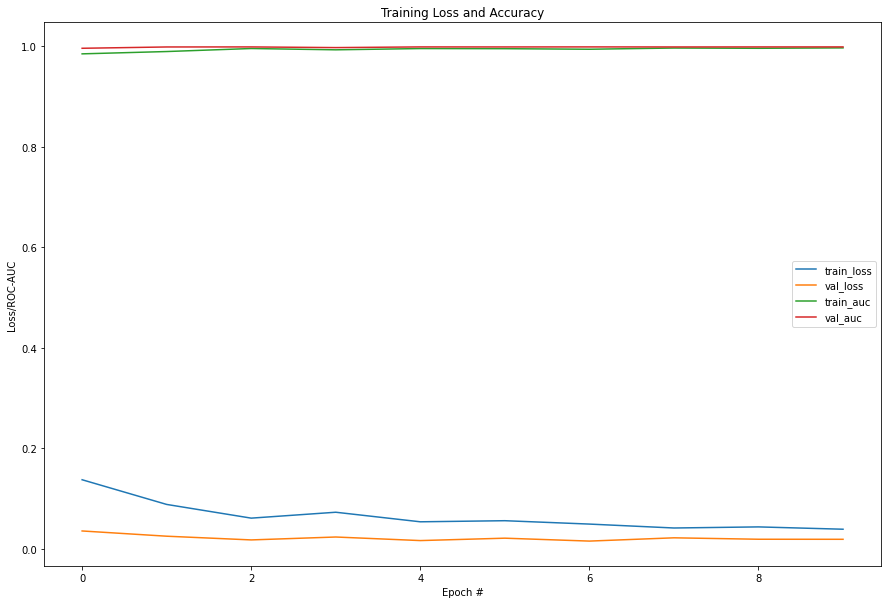

In [25]:
# vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC
N = Epochs
H_keys = list(H.history.keys())
# plt.style.use("ggplot")
plt.figure(figsize = (15,10))
plt.plot(np.arange(0, N), H.history[H_keys[0]], label="train_loss")
plt.plot(np.arange(0, N), H.history[H_keys[2]], label="val_loss")
plt.plot(np.arange(0, N), H.history[H_keys[1]], label="train_auc")
plt.plot(np.arange(0, N), H.history[H_keys[3]], label="val_auc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/ROC-AUC")
plt.legend(loc="center right");

# 5. Kiểm tra mô hình

Nhắc lại, quá trình nhận diện một gương mặt có đeo khẩu trang hay không được thực hiện theo từng bước sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Trong phần này chúng ta sẽ thực hiện việc kiểm tra mô hình nhận diện đeo khẩu trang. Về phần nhận diện gương mặt chúng ta sẽ sử dụng mô hình MTCNN với các hàm và thư viện mà chúng ta đã cung cấp sẵn

- Import các thư viện cần thiết cho việc kiểm tra

In [26]:
!cp /content/ASM_ORIGIN/align_faces.py /content/
from align_faces import warp_and_crop_face, get_reference_facial_points

In [27]:
!cp -r /content/ASM_ORIGIN/mtcnn /content/mtcnn
from mtcnn.detector import MtcnnDetector

In [28]:
from tensorflow.keras.models import load_model
#model = load_model(save_path+model_name)  #EfficientNetB0.h5

- Sử dụng hàm nhận diện gương mặt có sẵn đã được cung cấp để tiến hành Face Detection và Face Alignment trước khi nhận diện khẩu trang.

**Lưu ý**: Hàm này có thể không hoạt động được và trả về lỗi nếu trong bức ảnh không có gương mặt nào hoặc trong một vài trường hợp không thể nhận diện được ảnh trong gương mặt

**Có thể học viên sẽ thắc mắc tại sao chúng ta phải sử dụng Face Alignemnt?**

Đúng như tên gọi của nó: Alignment (sự căn chỉnh), Face Alignment giúp khuôn mặt dù có bị quay ngang, bị chéo mặt hay thậm chị bị mất nhiều chi tiết do điều kiện ngoại cảnh, lệch ra khỏi khung hình... cũng có thể "căn chỉnh" lại về trung tâm bức ảnh với hướng mặt thẳng chính giữa như mong muốn được. Sau bước detection thì các khuôn mặt của chúng ta có thể ở các trạng thái khác nhau hoặc các góc độ khác nhau, có những khuôn mặt bị chéo và cũng có thể bị lệch do bước detect chưa chính xác trong việc lấy ra khung hình chuẩn của mặt. Thì việc áp dụng Face Alignment ở đây là cần thiết, nó có thể hiểu như một hình thức của data normalization (chuẩn hóa dữ liệu), giúp tiêu chuẩn hoá lại dữ liệu trước khi đưa vào mô hình phân loại (binary classcification), điều này giúp cho mô hình có kết quả dự đoán chính xác hơn. Học viên có thể so sánh với **mô hình chỉ có Face Detection mà không có Face Alignment** với mô hình ở phía dưới để so sánh kết quả xem liệu sự có mặt của Face Alignment liệu thật sự có cải thiện kết quả hay không.

In [29]:
def face_detection(img, output_size, align = False):
    """Nếu align == True thì sẽ có thêm bước Face Alignment sau khi nhận diện gương mặt,
        ngược lại thì không có thêm bước này"""
    
    # Nhận diện gương mặt
    boxes, facial5points = MtcnnDetector().detect_faces(img)
    
    # Tiến hành Alignment
    if align == True:
        if len(facial5points) != 0:
            facial5points = np.reshape(facial5points[0], (2, 5))

            default_square = True
            inner_padding_factor = 0.25
            outer_padding = (0, 0)

            ## Yêu cầu 10:
            ## VIẾT CODE Ở ĐÂY:
            # sử dụng hàm get_reference_facial_points
            reference_5pts = get_reference_facial_points(
                output_size, inner_padding_factor, outer_padding, default_square)           
            # sử dụng hàm warp_and_crop_face
            face = warp_and_crop_face(src_img = img, 
                        facial_pts = facial5points, 
                        reference_pts = reference_5pts,
                        crop_size = output_size)
               
    # Không Alignment
    else:
        (h,w) = img.shape[:2]
        if len(boxes) != 0:
            for box in boxes:
                (startX, startY, endX, endY) = box[:4].astype('int')
                (startX, startY) = (max(0, startX),max(0, startY))
                (endX, endY) = (min(w-1, endX), min(h-1, endY))
                face = img[startY:endY, startX:endX]
                face = cv2.resize(face, output_size)
                
    return face

- Tạo ra mảng chứa các ảnh sau đã thực hiện việc nhận diện gương mặt

In [30]:
test_X_align = test_X.copy()

- Như đã lưu ý ở trên, có thể có một vài bức ảnh không thể nhận diện gương mặt được với hàm này, cho nên chúng ta sẽ chỉ lựa chọn ra các bức ảnh chỉ nhận diện được và lưu chỉ mục của chúng vào mảng **choose**. Sử dụng cấu trúc **try-except** để xử lý lỗi trong trường hợp này

In [31]:
choose = []
#chooseF = []
for i in range(len(test_X)):
    try:
        # Tiến hành nhận diện gương mặt kết hợp với Face Alignement, trả về kích thươc ảnh là 224x224
        ## Yêu cầu 11:
        ## VIẾT CODE Ở ĐÂY:
        b, f = MtcnnDetector().detect_faces(test_X_align[i])
        if len(b) > 0:
            test_X_align[i] = face_detection(test_X[i].astype('uint8'), (224, 224), align = True)
        # Lưu chỉ mục của ảnh đã nhận diện thành công vào mảng choose
            choose.append(i)
        else: 
            test_X_align[i] = face_detection(test_X[i].astype('uint8'), (224, 224), align = False)
            choose.append(i)
            #chooseF.append(i)
    except:
        # Nếu tấm ảnh không nhận diện được thì chúng ta sẽ bỏ qua tấm này
        continue
choose =  np.array(choose)

In [32]:
test_X_align.shape

(3200, 224, 224, 3)

In [33]:
test_X_align[choose, :, :, :].shape

(1761, 224, 224, 3)

- Chúng ta sẽ sử dụng chỉ số **ROC-AUC** làm chỉ số đánh giá mô hình

In [34]:
from sklearn.metrics import roc_auc_score

- Lọc ra các tấm ảnh với mảng choose và tiến hành tính chỉ số ROC-AUC

In [35]:
## Yêu cầu 12:
## VIẾT CODE Ở ĐÂY:
pred = model.predict(test_X_align[choose])
y_pred = np.argmax(pred, axis = 1)
ROC_AUC = roc_auc_score(np.argmax(test_Y[choose], axis = 1), y_pred)
ROC_AUC

0.9703220008338118

## 5.1 Multi-faces

Nếu ở phần trên chúng ta chỉ nhận diện tấm ảnh chỉ có một gương mặt duy nhất thì ở phần này chúng ta sẽ nhận diện nhiều gương mặt có đeo khẩu trang hay không trong cùng một bức ảnh với mô hình ở trên

- Sử dụng hàm có sẵn

In [36]:
def mask_detect(image):
    
    img = image.copy()
    (h,w) = img.shape[:2]
    boxes, facial5points = MtcnnDetector().detect_faces(img)
    for box in boxes:
        (startX,startY,endX,endY)=box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))

        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=img[startY:endY, startX:endX]
        face=cv2.resize(face,(224,224))

        (mask,withoutMask)=model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)

        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(img,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(img,(startX,startY),(endX,endY),color,2)
        
    return img

- Nhận diện một vài bức ảnh có sẵn trong thư mục image

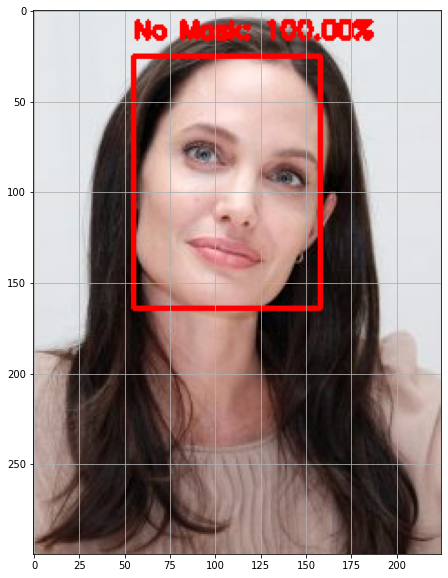

In [37]:
img = cv2.imread("/content/ASM_ORIGIN/image/angelina.jpg")
## Yêu cầu 13:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)
plt.figure(figsize = (10,10))
plt.imshow(img[:, :, ::-1])
plt.grid(None)
##Báo lỗi Không mở được cửa sổ ngoài khi dùng colab
#cv2.imshow("OutPut",img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

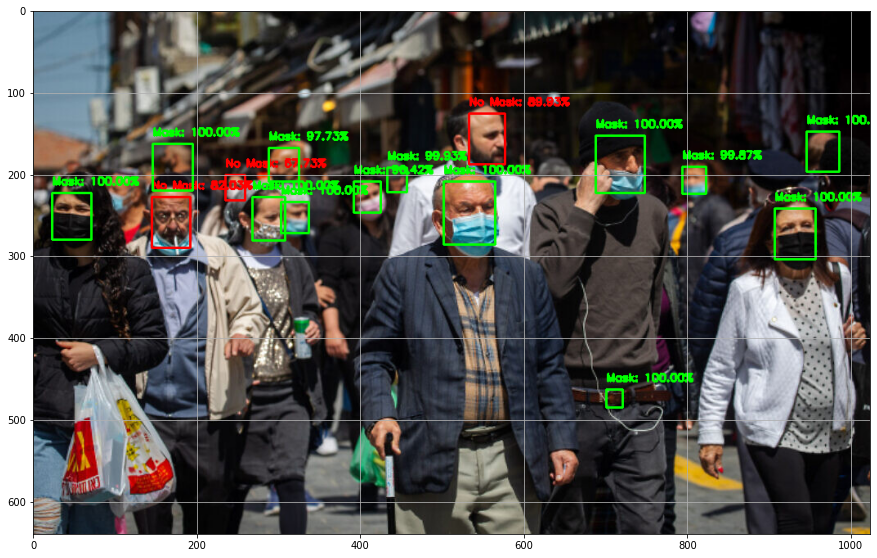

In [38]:
img_people = cv2.imread("/content/ASM_ORIGIN/image/people.jpg")
## Yêu cầu 14:
## VIẾT CODE Ở ĐÂY:
img_people = mask_detect(img_people)
plt.figure(figsize = (15,10))
plt.imshow(img_people[:, :, ::-1])
plt.grid(None)
##Báo lỗi Không mở được cửa sổ ngoài khi dùng colab
#cv2.imshow("OutPut",img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

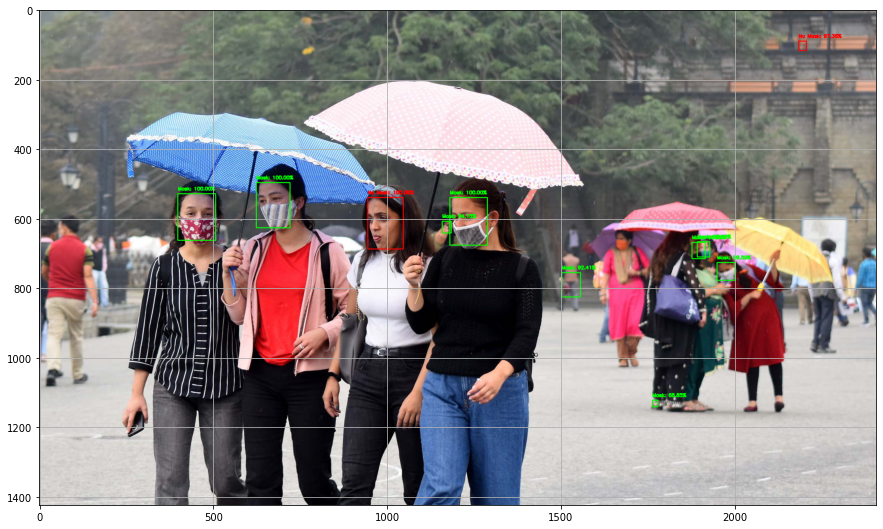

In [39]:
img_woman = cv2.imread("/content/ASM_ORIGIN/image/woman.jpg")
## Yêu cầu 15:
## VIẾT CODE Ở ĐÂY:
img_woman = mask_detect(img_woman)
plt.figure(figsize = (15,10))
plt.imshow(img_woman[:, :, ::-1])
plt.grid(None)
##Báo lỗi Không mở được cửa sổ ngoài khi dùng colab
#cv2.imshow("OutPut",img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

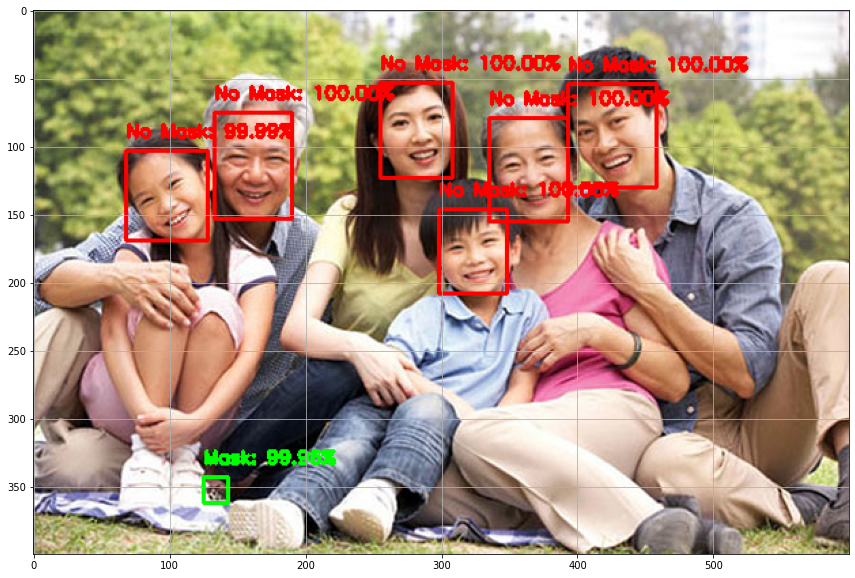

In [40]:
img_family = cv2.imread("/content/ASM_ORIGIN/image/family.jpg")
## Yêu cầu 16:
## VIẾT CODE Ở ĐÂY:
img_family = mask_detect(img_family)
plt.figure(figsize = (15,10))
plt.imshow(img_family[:, :, ::-1])
plt.grid(None)
##Báo lỗi Không mở được cửa sổ ngoài khi dùng colab
#cv2.imshow("OutPut",img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

## 5.2 Video

Ở phần này chúng ta sẽ nhận diện gương mặt đeo khẩu trang theo thời gian thực thông qua camera của máy tính

In [41]:
#Load lại một số module cần thiết
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Load bổ sung một số module ngoài
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector
from cap_video_MiAI import *
# Load mô hình mà ta đã đào tạo
from tensorflow.keras.models import load_model
model = load_model(save_path+model_name)
classes = ['with mask', 'without mask']

In [42]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Đang lấy hình ảnh...'
# initialze bounding box to empty
bbox = ''
count = 0 

while True:
    # Đọc ảnh trả về từ JS
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # Tạo một layer trắng để vẽ box:
    (h, w) = frame.shape[:2]
    bbox_array = np.zeros([h,w,4], dtype=np.uint8)

    # Code lấy tọa độ 2 điểm rectang của khuôn mặt
    boxes, facial5points = MtcnnDetector().detect_faces(frame)
    # do ảnh có thể có nhiều khuôn mặt, ta dùng vòng lặp qua từng face
    for box in boxes:
        (startX, startY, endX, endY) = box[:4].astype('int')
        # Điều chỉnh lại vị trí
        (startX, startY) = (max(0, startX),max(0, startY))
        (endX, endY) = (min(w-1, endX), min(h-1, endY))

        #tìm kiếm khuôn mặt trong ảnh
        face = frame[startY:endY, startX:endX]
        face = cv2.resize(face,(224,224))
        #Tạo nhãn và chỉ định màu sắc cho nhãn
        (mask, withoutMask) = model.predict(face.reshape(1,224,224,3))[0]
        label = 'Mask' if mask > withoutMask else 'No Mask'
        if label == 'Mask': color = (0, 255, 0) #màu xanh lá
        else: color = (255, 0, 0)               #màu đỏ
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(bbox_array, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(bbox_array, (startX, startY), (endX, endY), color, 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes    

<IPython.core.display.Javascript object>

# 6. Cải thiện mô hình

- Phần này học viên sẽ tự đề xuất và thực thi các phương pháp khác nhau nhằm mục đích cải thiện chất lượng mô hình tốt hơn có thể có. Tức là chỉ số **ROC-AUC >= 0.992**. Một số phương pháp được đề xuất như sau:

1. Cải thiện model nhận diện đeo khẩu trang.

2. Cải thiện model phát hiện khuôn mặt.

3. Sử dụng thêm dữ liệu cho quá trình huấn luyện.

4. Cải thiện phần face alignment

In [ ]:
## Yêu cầu 17:
## VIẾT CODE Ở ĐÂY:

In [ ]:
from make_dataset import *
make_data = make_dataset(12000) # tăng số lượng mẫu ảnh lên 12000
(train_X, test_X, val_X, train_Y, test_Y, val_Y) = make_data

Số lượng ảnh trong tập list :  12000
Số lượng nhãn trong labels :  12000


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
from tensorflow.keras.applications import EfficientNetV2B1
#Khởi tạo mô hình model2, bổ sung thêm các lớp Dense với hàm kích hoạt relu
base_model2 = EfficientNetV2B1(include_top=False,
                       weights='imagenet',
                       input_tensor = Input(shape = (224, 224, 3)))
headModel2 = base_model2.output
headModel2 = AveragePooling2D()(headModel2)
headModel2 = Flatten(name = 'Flatten')(headModel2)
headModel2 = Dense(512, activation = 'relu')(headModel2)
headModel2 = Dense(128, activation = 'relu')(headModel2)
headModel2 = Dense(64, activation = 'relu')(headModel2)
headModel2 = Dropout(rate = 0.5)(headModel2)
headModel2 = Dense(2, activation = 'softmax')(headModel2)
model2 = Model(inputs = base_model2.input, outputs = headModel2)
# đóng băng các layer của mô hình EfficientNetV2B1
for layer2 in base_model2.layers:
    layer2.trainable = False

In [ ]:
#Biên dịch mô hình với alpha=0.001, MiniBatch = 32, Epoch = 12
model2.compile(loss='binary_crossentropy',
              optimizer= Adam(learning_rate = 0.001, decay = 0.0001),
              metrics=[tf.keras.metrics.AUC()])
# tiến hành tăng cường dữ liệu
aug = ImageDataGenerator(rotation_range=20, # xoay hình trong khoảng 0-20 độ
                          zoom_range=0.2, # phóng to ảnh
                          width_shift_range=0.2, # dịch chuyển ảnh theo chiều rộng
                          height_shift_range=0.2, # dịch chuyển ảnh theo chiều cao
                          shear_range=0.15, # cắt ảnh
                          horizontal_flip=True, # lật ảnh trên trục hoành
                          vertical_flip = True, # lật ảnh trên trục tung
                          fill_mode = 'nearest')
#Khớp mô hình
H2 = model2.fit(
    aug.flow(train_X, train_Y, batch_size=32, shuffle=True, seed=42 ),
    steps_per_epoch = len(train_X)//32,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//32,
    epochs = 12)

Epoch 1/12
281/281 [==============================] - 123s 376ms/step - loss: 0.0877 - auc: 0.9917 - val_loss: 0.0308 - val_auc: 0.9946
Epoch 2/12
281/281 [==============================] - 98s 348ms/step - loss: 0.0527 - auc: 0.9951 - val_loss: 0.0214 - val_auc: 0.9973
Epoch 3/12
281/281 [==============================] - 102s 363ms/step - loss: 0.0387 - auc: 0.9967 - val_loss: 0.0211 - val_auc: 0.9973
Epoch 4/12
281/281 [==============================] - 101s 358ms/step - loss: 0.0346 - auc: 0.9971 - val_loss: 0.0267 - val_auc: 0.9959
Epoch 5/12
281/281 [==============================] - 99s 351ms/step - loss: 0.0314 - auc: 0.9975 - val_loss: 0.0105 - val_auc: 0.9973
Epoch 6/12
281/281 [==============================] - 100s 356ms/step - loss: 0.0186 - auc: 0.9987 - val_loss: 0.0266 - val_auc: 0.9973
Epoch 7/12
281/281 [==============================] - 99s 353ms/step - loss: 0.0258 - auc: 0.9979 - val_loss: 0.0239 - val_auc: 0.9973
Epoch 8/12
281/281 [==============================]

In [ ]:
# lưu mô hình lại để tiện cho việc tái sử dụng sau này
#save_path2 = '/content/drive/MyDrive/DSP304/ASM/Asm1/'
#model_name2 = 'EfficientNetV2B1'
#model2.save(save_path2+model_name2)

In [ ]:
# Load lại mô hình
#model2 = load_model(save_path2+model_name2)

In [ ]:
from sklearn.metrics import roc_auc_score
pred_2 = model2.predict(test_X)
y_pred2 = np.argmax(pred_2, axis = 1)
ROC_AUC2 = roc_auc_score(np.argmax(test_Y, axis = 1), y_pred2)
ROC_AUC2

0.9968888888888888

<font color = blue> Ta thấy với việc điều chỉnh mô hình gốc từ **EfficientNet** sang **EfficientNet_v2**, kết hợp với việc thêm dữ liệu và thêm các layer giúp cho mô hình có độ chính xác cao hơn, đáp ứng mục tiêu đưa chỉ số ROC-AUC = 0.9968 > 0.992 </font>

_____________